In [1]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
# Make plots inline
%matplotlib inline
import urllib.request
import os
from scipy.io import loadmat
from math import floor


In [2]:
X = torch.linspace(-2,2,10000).reshape(-1,1)
y = torch.sin(X)

train_n = int(floor(1 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [4]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = torch.linspace(-2,2,5).reshape(-1,1)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [5]:
num_epochs = 200


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
#         print(output.mean.size())
        y_batch=y_batch.reshape(-1,)
#         print(y_batch.size())
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

/home/oem/v_torch/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean])
means = means[1:]

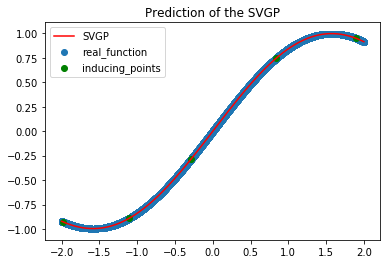

In [7]:
y=model(train_x).mean
x_inducing=model.variational_strategy.inducing_points
y_inducing=model(x_inducing).mean
plt.scatter(X,y.detach().cpu())
plt.title('Prediction of the SVGP')
plt.plot(X.cpu(),y.detach().cpu(), 'red')
plt.scatter(x_inducing.detach().cpu(),y_inducing.detach().cpu() ,color='green')
plt.legend(['SVGP', 'real_function', 'inducing_points'])

In [8]:
kernel=model.covar_module
k_star=kernel(X.cpu(),x_inducing)
K=kernel(x_inducing,x_inducing)
alpha=K.inv_matmul(y_inducing)
y_gp= kernel(X.cpu(),x_inducing.detach().cpu()).cpu().matmul(alpha.detach().cpu())

Text(0.5, 1.0, 'Prediction with smaller model')

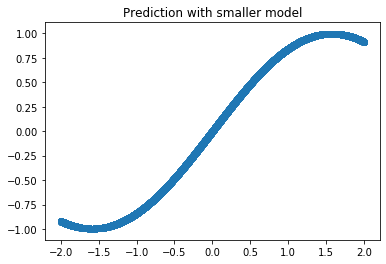

In [9]:
plt.scatter(X.cpu(),y_gp.detach().cpu())
plt.title('Prediction with smaller model')

# Read the noise of the kernel in Torch

In [10]:
likelihood.noise

tensor([0.0008], device='cuda:0', grad_fn=<AddBackward0>)